=== Port Scheduling Optimization Model - Full Version ===

Sample data generation completed:
Number of ships: 10
Number of berths: 5
Number of tugboats: 5
Time range: 24

=== Horsepower Distribution Information ===
Tugboat horsepower:
  Tugboat0: 3111hp (Large)
  Tugboat1: 3539hp (Large)
  Tugboat2: 2907hp (Large)
  Tugboat3: 1182hp (Small)
  Tugboat4: 1352hp (Small)

Ship horsepower requirements:
  Ship0: 931hp (Small) 
  Ship1: 3579hp (Very Large) Needs multiple tugboats
  Ship2: 971hp (Small) 
  Ship3: 2690hp (Large) 
  Ship4: 846hp (Small) 
  Ship5: 687hp (Small) 
  Ship6: 3783hp (Very Large) Needs multiple tugboats
  Ship7: 1331hp (Medium) 
  Ship8: 5751hp (Very Large) Needs multiple tugboats
  Ship9: 1471hp (Medium) 

Ships expected to need multiple tugboats: [1, 6, 8]

Building mathematical model...
Set parameter LicenseID to value 2613782
Adding constraints...
Setting objective function...
Starting to solve...
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0

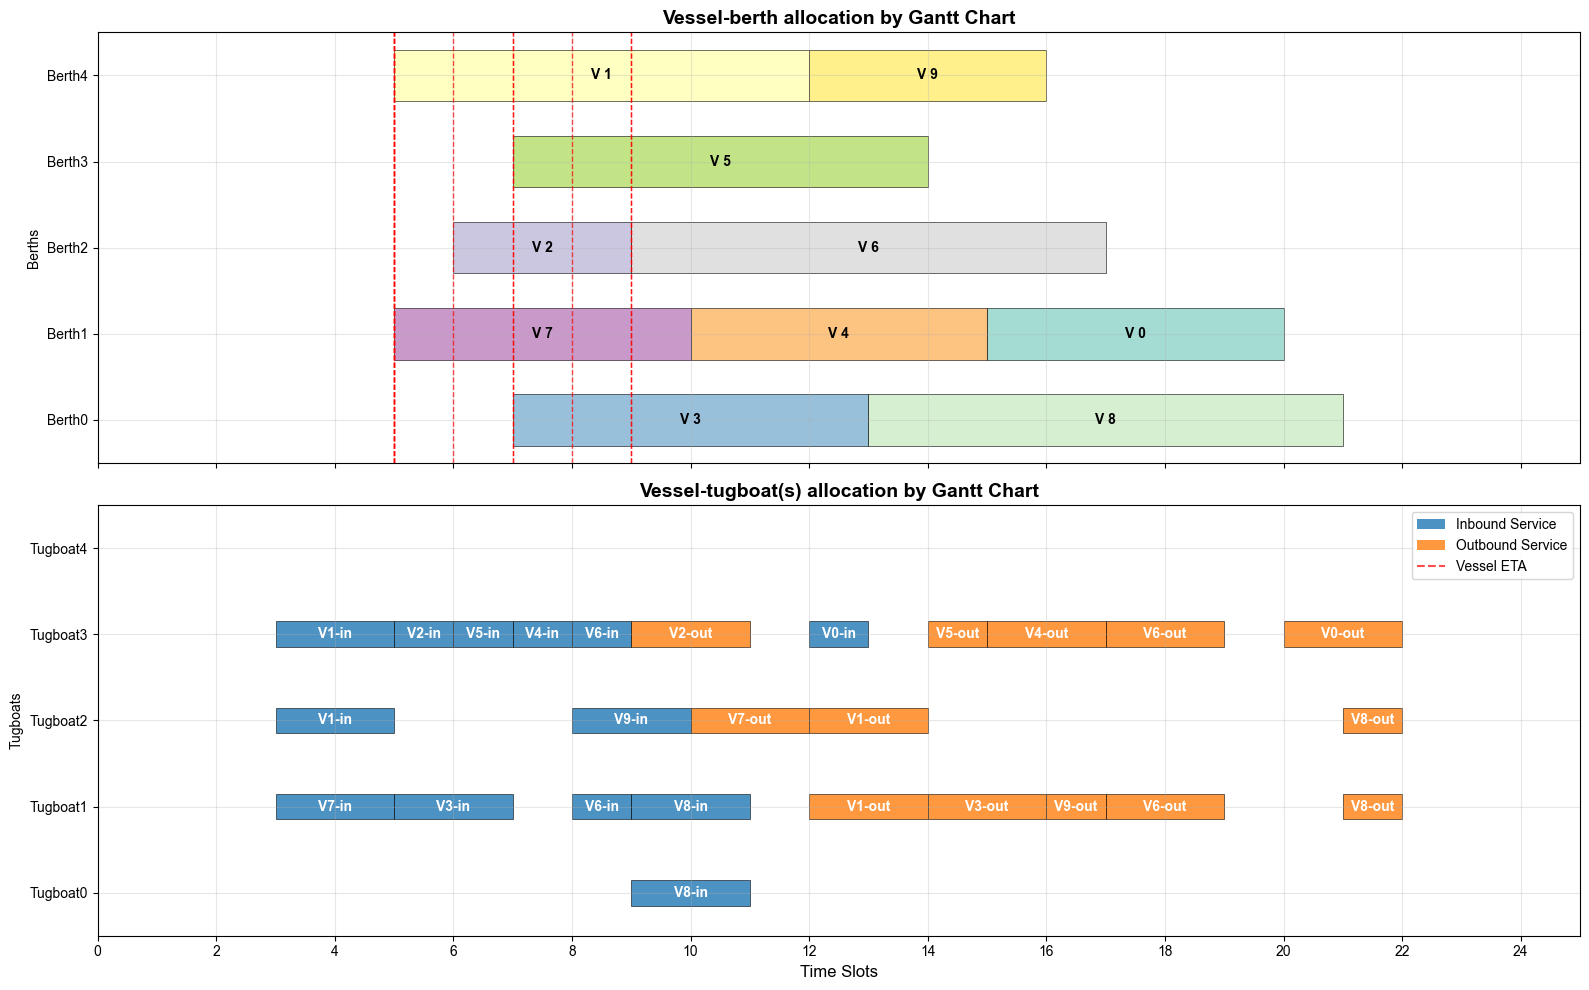


=== Scheduling Statistics ===
Total ships: 10
Scheduled ships: 10
Unscheduled ships: 0
Scheduling success rate: 100.0%

Berth utilization:
  Berth0: 58.3% (14/24 periods)
  Berth1: 62.5% (15/24 periods)
  Berth2: 45.8% (11/24 periods)
  Berth3: 29.2% (7/24 periods)
  Berth4: 45.8% (11/24 periods)

Tugboat utilization:
  Tugboat0: 8.3% (2/24 periods)
  Tugboat1: 62.5% (15/24 periods)
  Tugboat2: 37.5% (9/24 periods)
  Tugboat3: 66.7% (16/24 periods)
  Tugboat4: 0.0% (0/24 periods)

Tugboat cooperation analysis:
  Ship1 inbound: 2 tugboats cooperating (Requirement 3579hp, Providing 4089hp)
  Ship1 outbound: 2 tugboats cooperating (Requirement 3579hp, Providing 6446hp)
  Ship6 inbound: 2 tugboats cooperating (Requirement 3783hp, Providing 4721hp)
  Ship6 outbound: 2 tugboats cooperating (Requirement 3783hp, Providing 4721hp)
  Ship8 inbound: 2 tugboats cooperating (Requirement 5751hp, Providing 6650hp)
  Ship8 outbound: 2 tugboats cooperating (Requirement 5751hp, Providing 6446hp)
  Sing

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import random
from typing import Dict, List, Set, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

# Set font
plt.rcParams["font.family"] = "Arial"

class PortSchedulingModel:
    def __init__(self):
        """Initialize port scheduling model"""
        self.model = None
        self.variables = {}
        self.parameters = {}
        
    def generate_sample_data(self, num_ships=10, num_berths=5, num_tugs=8, time_horizon=48):
        """Generate sample data"""
        random.seed(42)  # Set random seed for reproducible results
        
        # Basic sets
        self.I = list(range(num_ships))  # Ship set
        self.J = list(range(num_berths))  # Berth set
        self.K = list(range(num_tugs))  # Tugboat set
        self.T = list(range(1, time_horizon + 1))  # Time set
        
        # Ship-berth compatibility
        self.J_i = {}  # Set of berths that ship i can dock at
        self.I_j = {j: [] for j in self.J}  # Set of ships that berth j can accommodate
        
        for i in self.I:
            # Each ship can dock at 2-4 berths
            num_compatible = random.randint(2, min(4, len(self.J)))
            self.J_i[i] = random.sample(self.J, num_compatible)
            for j in self.J_i[i]:
                self.I_j[j].append(i)
        
        # Time-related parameters
        self.ETA = {}  # Expected arrival time period
        self.D = {}    # Berthing operation duration
        self.tau_in = {}   # Inbound tugboat service duration
        self.tau_out = {}  # Outbound tugboat service duration
        self.Delta_early = {}  # Maximum allowed early time periods
        self.Delta_late = {}   # Maximum allowed late time periods
        
        for i in self.I:
            self.ETA[i] = random.randint(5, time_horizon - 15)
            self.D[i] = random.randint(3, 8)  # Operation duration 3-8 periods
            self.tau_in[i] = random.randint(1, 2)   # Inbound service duration
            self.tau_out[i] = random.randint(1, 2)  # Outbound service duration
            self.Delta_early[i] = random.randint(2, 5)  # Allowed early periods
            self.Delta_late[i] = random.randint(3, 8)   # Allowed late periods
        
        # Cost-related parameters
        self.alpha = {i: random.uniform(0.5, 2.0) for i in self.I}  # Priority weight
        self.beta = {i: random.uniform(10, 50) for i in self.I}     # Unit waiting cost
        self.gamma = {i: random.uniform(20, 100) for i in self.I}   # Unit JIT deviation cost
        self.c = {k: random.uniform(50, 150) for k in self.K}       # Tugboat unit time period usage cost
        
        # Horsepower-related parameters - Modified for more realistic settings
        # Tugboat horsepower distribution: small, medium, large tugboats
        self.P = {}
        for k in self.K:
            tug_type = random.choice(['small', 'medium', 'large'])
            if tug_type == 'small':
                self.P[k] = random.randint(800, 1500)    # Small tugboat
            elif tug_type == 'medium':
                self.P[k] = random.randint(1500, 2500)   # Medium tugboat
            else:
                self.P[k] = random.randint(2500, 4000)   # Large tugboat
        
        # Ship horsepower requirements: Set based on ship size, some large ships need multiple tugboats
        self.P_req = {}
        for i in self.I:
            ship_type = random.choice(['small', 'medium', 'large', 'very_large'])
            if ship_type == 'small':
                self.P_req[i] = random.randint(600, 1200)    # Small ship
            elif ship_type == 'medium':
                self.P_req[i] = random.randint(1200, 2200)   # Medium ship
            elif ship_type == 'large':
                self.P_req[i] = random.randint(2200, 3500)   # Large ship
            else:
                self.P_req[i] = random.randint(3500, 6000)   # Very large ship, needs multiple tugboats
        
        # System parameters
        self.H_max = 4      # Maximum number of tugboats allowed for single service
        self.epsilon_time = 2  # Maximum time deviation allowed for timing constraints
        self.M = 10000      # Big number parameter
        
        # Objective function weight coefficients
        self.lambda1 = 1.0  # Unserved penalty weight
        self.lambda2 = 1.0  # Total time in port cost weight
        self.lambda3 = 1.0  # ETA deviation cost weight
        self.lambda4 = 1.0  # Tugboat usage cost weight
        
        print("Sample data generation completed:")
        print(f"Number of ships: {len(self.I)}")
        print(f"Number of berths: {len(self.J)}")
        print(f"Number of tugboats: {len(self.K)}")
        print(f"Time range: {len(self.T)}")
        
        # Display horsepower distribution information
        print("\n=== Horsepower Distribution Information ===")
        print("Tugboat horsepower:")
        for k in self.K:
            tug_type = "Small" if self.P[k] <= 1500 else "Medium" if self.P[k] <= 2500 else "Large"
            print(f"  Tugboat{k}: {self.P[k]}hp ({tug_type})")
        
        print("\nShip horsepower requirements:")
        multi_tug_ships = []
        max_single_tug_power = max(self.P.values())
        for i in self.I:
            ship_type = ("Small" if self.P_req[i] <= 1200 else 
                        "Medium" if self.P_req[i] <= 2200 else 
                        "Large" if self.P_req[i] <= 3500 else "Very Large")
            need_multi = "Needs multiple tugboats" if self.P_req[i] > max_single_tug_power else ""
            if self.P_req[i] > max_single_tug_power:
                multi_tug_ships.append(i)
            print(f"  Ship{i}: {self.P_req[i]}hp ({ship_type}) {need_multi}")
        
        if multi_tug_ships:
            print(f"\nShips expected to need multiple tugboats: {multi_tug_ships}")
        
    def build_model(self):
        """Build Gurobi model"""
        self.model = gp.Model("PortScheduling")
        
        # Decision variables
        # x[i,j,t]: Ship i starts berthing at berth j in time period t
        self.x = {}
        for i in self.I:
            for j in self.J_i[i]:
                for t in self.T:
                    self.x[i,j,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                         name=f"x_{i}_{j}_{t}")
        
        # y_in[i,k,t]: Tugboat k starts inbound service for ship i in time period t
        self.y_in = {}
        for i in self.I:
            for k in self.K:
                for t in self.T:
                    # Apply tugboat service boundary constraints
                    if (t >= self.ETA[i] - self.Delta_early[i] and 
                        t <= self.ETA[i] + self.Delta_late[i]):
                        self.y_in[i,k,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                             name=f"y_in_{i}_{k}_{t}")
        
        # y_out[i,k,t]: Tugboat k starts outbound service for ship i in time period t
        self.y_out = {}
        for i in self.I:
            for k in self.K:
                for t in self.T:
                    self.y_out[i,k,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                          name=f"y_out_{i}_{k}_{t}")
        
        # z_in[i,t]: Ship i starts inbound tugboat service in time period t (auxiliary variable)
        self.z_in = {}
        for i in self.I:
            for t in self.T:
                if (t >= self.ETA[i] - self.Delta_early[i] and 
                    t <= self.ETA[i] + self.Delta_late[i]):
                    self.z_in[i,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                       name=f"z_in_{i}_{t}")
        
        # z_out[i,t]: Ship i starts outbound tugboat service in time period t (auxiliary variable)
        self.z_out = {}
        for i in self.I:
            for t in self.T:
                self.z_out[i,t] = self.model.addVar(vtype=GRB.BINARY, 
                                                    name=f"z_out_{i}_{t}")
        
        # u_early[i]: Early time of ship i relative to ETA
        self.u_early = {}
        for i in self.I:
            self.u_early[i] = self.model.addVar(vtype=GRB.CONTINUOUS, lb=0,
                                               name=f"u_early_{i}")
        
        # u_late[i]: Late time of ship i relative to ETA
        self.u_late = {}
        for i in self.I:
            self.u_late[i] = self.model.addVar(vtype=GRB.CONTINUOUS, lb=0,
                                              name=f"u_late_{i}")
        
        self.model.update()
        
    def add_constraints(self):
        """Add constraints"""
        
        # Constraint (1): Each ship assigned at most once
        for i in self.I:
            self.model.addConstr(
                gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T) <= 1,
                name=f"ship_assign_{i}"
            )
        
        # Constraint (2): Inbound tugboat and berth coupling
        for i in self.I:
            self.model.addConstr(
                gp.quicksum(self.z_in.get((i,t), 0) for t in self.T) == 
                gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T),
                name=f"tug_berth_in_{i}"
            )
        
        # Constraint (3): Outbound tugboat and berth coupling
        for i in self.I:
            self.model.addConstr(
                gp.quicksum(self.z_out.get((i,t), 0) for t in self.T) == 
                gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T),
                name=f"tug_berth_out_{i}"
            )
        
        # Constraint (4): Tugboat horsepower constraint
        for i in self.I:
            for t in self.T:
                if (i,t) in self.z_in:
                    self.model.addConstr(
                        gp.quicksum(self.P[k] * self.y_in.get((i,k,t), 0) for k in self.K) >= 
                        self.P_req[i] * self.z_in[i,t],
                        name=f"power_in_{i}_{t}"
                    )
                if (i,t) in self.z_out:
                    self.model.addConstr(
                        gp.quicksum(self.P[k] * self.y_out.get((i,k,t), 0) for k in self.K) >= 
                        self.P_req[i] * self.z_out[i,t],
                        name=f"power_out_{i}_{t}"
                    )
        
        # Constraint (6): Tugboat quantity limit
        for i in self.I:
            for t in self.T:
                if (i,t) in self.z_in:
                    self.model.addConstr(
                        gp.quicksum(self.y_in.get((i,k,t), 0) for k in self.K) <= 
                        self.H_max * self.z_in[i,t],
                        name=f"tug_limit_in_{i}_{t}"
                    )
                if (i,t) in self.z_out:
                    self.model.addConstr(
                        gp.quicksum(self.y_out.get((i,k,t), 0) for k in self.K) <= 
                        self.H_max * self.z_out[i,t],
                        name=f"tug_limit_out_{i}_{t}"
                    )
        
        # Constraint (8): Auxiliary variable definition
        for i in self.I:
            for t in self.T:
                if (i,t) in self.z_in:
                    self.model.addConstr(
                        self.z_in[i,t] <= gp.quicksum(self.y_in.get((i,k,t), 0) for k in self.K),
                        name=f"aux_in_{i}_{t}"
                    )
                if (i,t) in self.z_out:
                    self.model.addConstr(
                        self.z_out[i,t] <= gp.quicksum(self.y_out.get((i,k,t), 0) for k in self.K),
                        name=f"aux_out_{i}_{t}"
                    )
        
        # Constraint (10): Berth capacity constraint
        for j in self.J:
            for t in self.T:
                berth_usage = []
                for i in self.I_j[j]:
                    for tau in range(max(1, t - self.D[i] + 1), t + 1):
                        if (i,j,tau) in self.x:
                            berth_usage.append(self.x[i,j,tau])
                
                if berth_usage:
                    self.model.addConstr(
                        gp.quicksum(berth_usage) <= 1,
                        name=f"berth_capacity_{j}_{t}"
                    )
        
        # Constraint (11): Tugboat capacity constraint
        for k in self.K:
            for t in self.T:
                tug_usage = []
                
                # Inbound service occupation
                for i in self.I:
                    for tau in range(max(1, t - self.tau_in[i] + 1), t + 1):
                        if (i,k,tau) in self.y_in:
                            tug_usage.append(self.y_in[i,k,tau])
                
                # Outbound service occupation
                for i in self.I:
                    for tau in range(max(1, t - self.tau_out[i] + 1), t + 1):
                        if (i,k,tau) in self.y_out:
                            tug_usage.append(self.y_out[i,k,tau])
                
                if tug_usage:
                    self.model.addConstr(
                        gp.quicksum(tug_usage) <= 1,
                        name=f"tug_capacity_{k}_{t}"
                    )
        
        # Constraint (13): Inbound timing constraint
        for i in self.I:
            assigned = gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T)
            
            if assigned.size() > 0:  # Only add constraint when ship might be assigned
                berth_start = gp.quicksum(t * self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T)
                tug_end = gp.quicksum((t + self.tau_in[i]) * self.z_in.get((i,t), 0) for t in self.T)
                
                self.model.addConstr(
                    berth_start - tug_end >= 0,
                    name=f"timing_in_lower_{i}"
                )
                self.model.addConstr(
                    berth_start - tug_end <= self.epsilon_time * assigned,
                    name=f"timing_in_upper_{i}"
                )
        
        # Constraint (14): Outbound timing constraint
        for i in self.I:
            assigned = gp.quicksum(self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T)
            
            if assigned.size() > 0:  # Only add constraint when ship might be assigned
                tug_start = gp.quicksum(t * self.z_out.get((i,t), 0) for t in self.T)
                berth_end = gp.quicksum((t + self.D[i]) * self.x.get((i,j,t), 0) for j in self.J_i[i] for t in self.T)
                
                self.model.addConstr(
                    tug_start - berth_end >= 0,
                    name=f"timing_out_lower_{i}"
                )
                self.model.addConstr(
                    tug_start - berth_end <= self.epsilon_time * assigned,
                    name=f"timing_out_upper_{i}"
                )
        
        # Constraint (15): ETA deviation linearization constraint
        for i in self.I:
            tug_start_time = gp.quicksum(t * self.z_in.get((i,t), 0) for t in self.T)
            
            self.model.addConstr(
                tug_start_time == self.ETA[i] + self.u_late[i] - self.u_early[i],
                name=f"eta_deviation_{i}"
            )
        
    def set_objective(self):
        """Set objective function"""
        
        # Z1: Unserved penalty
        Z1 = gp.quicksum(
            self.M * self.alpha[i] * (1 - gp.quicksum(self.x.get((i,j,t), 0) 
                                                      for j in self.J_i[i] for t in self.T))
            for i in self.I
        )
        
        # Z2: Total time in port cost
        Z2 = gp.quicksum(
            self.alpha[i] * self.beta[i] * (
                gp.quicksum((t + self.tau_out[i]) * self.z_out.get((i,t), 0) for t in self.T) -
                gp.quicksum(t * self.z_in.get((i,t), 0) for t in self.T)
            )
            for i in self.I
        )
        
        # Z3: ETA deviation cost
        Z3 = gp.quicksum(
            self.alpha[i] * self.gamma[i] * (self.u_early[i] + self.u_late[i])
            for i in self.I
        )
        
        # Z4: Tugboat usage cost
        Z4 = gp.quicksum(
            self.c[k] * (
                gp.quicksum(self.tau_in[i] * self.y_in.get((i,k,t), 0) 
                           for i in self.I for t in self.T) +
                gp.quicksum(self.tau_out[i] * self.y_out.get((i,k,t), 0) 
                           for i in self.I for t in self.T)
            )
            for k in self.K
        )
        
        # Total objective function
        objective = (self.lambda1 * Z1 + self.lambda2 * Z2 + 
                    self.lambda3 * Z3 + self.lambda4 * Z4)
        self.model.setObjective(objective, GRB.MINIMIZE)
        
    def solve(self):
        """Solve model"""
        
        # Set solver parameters
        self.model.Params.TimeLimit = 600  # 10 minute time limit
        self.model.Params.MIPGap = 0.05    # 5% gap
        self.model.Params.OutputFlag = 1   # Show solving process
        self.model.Params.Threads = 4      # Use 4 threads
        
        # Set heuristic parameters
        self.model.Params.Heuristics = 0.2  # 20% time for heuristics
        self.model.Params.MIPFocus = 1       # Focus on finding feasible solutions
        
        # Solve
        self.model.optimize()
        
        # Output results
        if self.model.Status == GRB.OPTIMAL:
            print("\n=== Solution Found Successfully ===")
            print(f"Optimal objective value: {self.model.ObjVal:.2f}")
            self.print_solution()
            self.analyze_solution()
        elif self.model.Status == GRB.TIME_LIMIT:
            print(f"\n=== Feasible Solution Found Within Time Limit ===")
            if hasattr(self.model, 'ObjVal'):
                print(f"Current best objective value: {self.model.ObjVal:.2f}")
                print(f"Gap: {self.model.MIPGap*100:.2f}%")
                self.print_solution()
                self.analyze_solution()
        else:
            print(f"\nSolving status: {self.model.Status}")
            if self.model.Status == GRB.INFEASIBLE:
                print("Model infeasible")
                self.model.computeIIS()
                self.model.write("infeasible.ilp")
                print("Infeasible system written to infeasible.ilp")
            elif self.model.Status == GRB.UNBOUNDED:
                print("Model unbounded")
                
    def print_solution(self):
        """Print solution"""
        print("\n=== Ship Scheduling Plan ===")
        
        scheduled_ships = []
        unscheduled_ships = []
        
        for i in self.I:
            assigned = False
            for j in self.J_i[i]:
                for t in self.T:
                    if (i,j,t) in self.x and self.x[i,j,t].X > 0.5:
                        # Find corresponding inbound and outbound tugboat services
                        in_time = None
                        out_time = None
                        in_tugs = []
                        out_tugs = []
                        
                        for t_tug in self.T:
                            if (i,t_tug) in self.z_in and self.z_in[i,t_tug].X > 0.5:
                                in_time = t_tug
                                for k in self.K:
                                    if (i,k,t_tug) in self.y_in and self.y_in[i,k,t_tug].X > 0.5:
                                        in_tugs.append(k)
                            
                            if (i,t_tug) in self.z_out and self.z_out[i,t_tug].X > 0.5:
                                out_time = t_tug
                                for k in self.K:
                                    if (i,k,t_tug) in self.y_out and self.y_out[i,k,t_tug].X > 0.5:
                                        out_tugs.append(k)
                        
                        eta_deviation = ""
                        if self.u_early[i].X > 0.01:
                            eta_deviation = f"(Early {self.u_early[i].X:.1f} periods)"
                        elif self.u_late[i].X > 0.01:
                            eta_deviation = f"(Late {self.u_late[i].X:.1f} periods)"
                        
                        # Calculate total tugboat horsepower
                        in_total_power = sum(self.P[k] for k in in_tugs)
                        out_total_power = sum(self.P[k] for k in out_tugs)
                        
                        print(f"Ship {i}: Berth {j}, Berthing periods {t}-{t+self.D[i]-1} (ETA: {self.ETA[i]}) {eta_deviation}")
                        print(f"         Required power: {self.P_req[i]}")
                        print(f"         Inbound: Period{in_time}, Tugboats{in_tugs} (Total power: {in_total_power})")
                        print(f"         Outbound: Period{out_time}, Tugboats{out_tugs} (Total power: {out_total_power})")
                        
                        scheduled_ships.append(i)
                        assigned = True
                        break
                if assigned:
                    break
            
            if not assigned:
                unscheduled_ships.append(i)
        
        if unscheduled_ships:
            print(f"\nUnassigned ships: {unscheduled_ships}")
        
        print(f"\nScheduling statistics:")
        print(f"Scheduled ships: {len(scheduled_ships)}/{len(self.I)}")
        print(f"Scheduling rate: {len(scheduled_ships)/len(self.I)*100:.1f}%")
        
    def analyze_solution(self):
        """Analyze solution"""
        if not hasattr(self.model, 'ObjVal'):
            return
            
        print("\n=== Objective Function Analysis ===")
        
        # Calculate objective function components
        Z1_val = 0  # Unserved penalty
        Z2_val = 0  # Total time in port cost
        Z3_val = 0  # ETA deviation cost
        Z4_val = 0  # Tugboat usage cost
        
        for i in self.I:
            assigned = sum(self.x.get((i,j,t), 0).X if (i,j,t) in self.x else 0 
                          for j in self.J_i[i] for t in self.T)
            
            if assigned < 0.5:  # Unassigned
                Z1_val += self.M * self.alpha[i]
            else:
                # Time in port cost
                in_time = sum(t * (self.z_in.get((i,t), 0).X if (i,t) in self.z_in else 0) 
                             for t in self.T)
                out_time = sum((t + self.tau_out[i]) * (self.z_out.get((i,t), 0).X if (i,t) in self.z_out else 0) 
                              for t in self.T)
                Z2_val += self.alpha[i] * self.beta[i] * (out_time - in_time)
                
                # ETA deviation cost
                Z3_val += self.alpha[i] * self.gamma[i] * (self.u_early[i].X + self.u_late[i].X)
        
        # Tugboat usage cost
        for k in self.K:
            for i in self.I:
                for t in self.T:
                    if (i,k,t) in self.y_in:
                        Z4_val += self.c[k] * self.tau_in[i] * self.y_in[i,k,t].X
                    if (i,k,t) in self.y_out:
                        Z4_val += self.c[k] * self.tau_out[i] * self.y_out[i,k,t].X
        
        print(f"Z1 (Unserved penalty): {Z1_val:.2f}")
        print(f"Z2 (Time in port cost): {Z2_val:.2f}")
        print(f"Z3 (ETA deviation cost): {Z3_val:.2f}")
        print(f"Z4 (Tugboat usage cost): {Z4_val:.2f}")
        print(f"Total cost: {Z1_val + Z2_val + Z3_val + Z4_val:.2f}")
        
        # Analyze tugboat usage
        print("\n=== Tugboat Usage Analysis ===")
        single_tug_count = 0
        multi_tug_count = 0
        
        for i in self.I:
            assigned = sum(self.x.get((i,j,t), 0).X if (i,j,t) in self.x else 0 
                          for j in self.J_i[i] for t in self.T)
            
            if assigned > 0.5:  # Assigned ships
                # Check number of tugboats for inbound service
                for t in self.T:
                    if (i,t) in self.z_in and self.z_in[i,t].X > 0.5:
                        in_tug_count = sum(1 for k in self.K 
                                         if (i,k,t) in self.y_in and self.y_in[i,k,t].X > 0.5)
                        if in_tug_count == 1:
                            single_tug_count += 1
                        elif in_tug_count > 1:
                            multi_tug_count += 1
                            print(f"  Ship{i} inbound: Using {in_tug_count} tugboats (Requirement {self.P_req[i]}hp)")
                        break
        
        total_services = single_tug_count + multi_tug_count
        if total_services > 0:
            print(f"\nSingle tugboat services: {single_tug_count} times ({single_tug_count/total_services*100:.1f}%)")
            print(f"Multi-tugboat services: {multi_tug_count} times ({multi_tug_count/total_services*100:.1f}%)")

    def export_results_to_excel(self, filename="port_schedule_results.xlsx"):
        """Export results to Excel file"""
        if not hasattr(self.model, 'ObjVal'):
            print("No solution results to export")
            return
        
        # Ship scheduling results
        schedule_data = []
        for i in self.I:
            row = {
                'Ship ID': i,
                'ETA': self.ETA[i],
                'Operation Duration': self.D[i],
                'Assigned Berth': None,
                'Berthing Start Period': None,
                'Berthing End Period': None,
                'Inbound Tugboat Service Period': None,
                'Inbound Tugboats': None,
                'Outbound Tugboat Service Period': None,
                'Outbound Tugboats': None,
                'ETA Early Periods': self.u_early[i].X,
                'ETA Late Periods': self.u_late[i].X
            }
            
            # Find assignment results
            for j in self.J_i[i]:
                for t in self.T:
                    if (i,j,t) in self.x and self.x[i,j,t].X > 0.5:
                        row['Assigned Berth'] = j
                        row['Berthing Start Period'] = t
                        row['Berthing End Period'] = t + self.D[i] - 1
                        break
                if row['Assigned Berth'] is not None:
                    break
            
            # Find tugboat services
            for t in self.T:
                if (i,t) in self.z_in and self.z_in[i,t].X > 0.5:
                    row['Inbound Tugboat Service Period'] = t
                    tugs = [k for k in self.K if (i,k,t) in self.y_in and self.y_in[i,k,t].X > 0.5]
                    row['Inbound Tugboats'] = ','.join(map(str, tugs))
                
                if (i,t) in self.z_out and self.z_out[i,t].X > 0.5:
                    row['Outbound Tugboat Service Period'] = t
                    tugs = [k for k in self.K if (i,k,t) in self.y_out and self.y_out[i,k,t].X > 0.5]
                    row['Outbound Tugboats'] = ','.join(map(str, tugs))
            
            schedule_data.append(row)
        
        # Create DataFrame and save
        df = pd.DataFrame(schedule_data)
        
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            df.to_excel(writer, sheet_name='Ship Scheduling Results', index=False)
            
        print(f"\nResults exported to {filename}")

    def extract_solution(self):
        """Extract solution results"""
        if not hasattr(self.model, 'ObjVal'):
            return None
        
        solution = {
            "assigned": [],    # Assigned ships (i, j, t)
            "unassigned": [],  # Unassigned ships
            "inbound": [],     # Inbound tugboat services (i, k, t)  
            "outbound": []     # Outbound tugboat services (i, k, t)
        }
        
        # Collect assigned ships
        for i in self.I:
            assigned = False
            for j in self.J_i[i]:
                for t in self.T:
                    if (i,j,t) in self.x and self.x[i,j,t].X > 0.5:
                        solution["assigned"].append((i, j, t))
                        assigned = True
                        break
                if assigned:
                    break
            
            if not assigned:
                solution["unassigned"].append(i)
        
        # Collect tugboat services
        for i in self.I:
            for k in self.K:
                for t in self.T:
                    if (i,k,t) in self.y_in and self.y_in[i,k,t].X > 0.5:
                        solution["inbound"].append((i, k, t))
                    if (i,k,t) in self.y_out and self.y_out[i,k,t].X > 0.5:
                        solution["outbound"].append((i, k, t))
        
        return solution
    
    def prepare_data_for_visualization(self):
        """Prepare visualization data"""
        data = {
            "D": self.D,           # Operation duration
            "Tin": self.tau_in,    # Inbound tugboat service duration
            "Tout": self.tau_out,  # Outbound tugboat service duration
            "ETA": self.ETA,       # Expected arrival time
            "P": self.P,           # Tugboat horsepower
            "P_req": self.P_req    # Ship horsepower requirements
        }
        
        meta = {
            "num_ships": len(self.I),
            "num_berths": len(self.J),
            "num_tugs": len(self.K),
            "time_horizon": len(self.T)
        }
        
        return data, meta
    
    def print_scheduling_statistics(self, solution, data):
        """Print scheduling statistics"""
        print("\n=== Scheduling Statistics ===")
        
        total_ships = len(self.I)
        assigned_ships = len(solution["assigned"])
        unassigned_ships = len(solution["unassigned"])
        
        print(f"Total ships: {total_ships}")
        print(f"Scheduled ships: {assigned_ships}")
        print(f"Unscheduled ships: {unassigned_ships}")
        print(f"Scheduling success rate: {assigned_ships/total_ships*100:.1f}%")
        
        # Berth utilization
        berth_usage = {j: 0 for j in self.J}
        for (i, j, t) in solution["assigned"]:
            berth_usage[j] += data["D"][i]
        
        print(f"\nBerth utilization:")
        total_time = len(self.T)
        for j in self.J:
            utilization = berth_usage[j] / total_time * 100
            print(f"  Berth{j}: {utilization:.1f}% ({berth_usage[j]}/{total_time} periods)")
        
        # Tugboat utilization
        tug_usage = {k: 0 for k in self.K}
        for (i, k, t) in solution["inbound"]:
            tug_usage[k] += data["Tin"][i]
        for (i, k, t) in solution["outbound"]:
            tug_usage[k] += data["Tout"][i]
        
        print(f"\nTugboat utilization:")
        for k in self.K:
            utilization = tug_usage[k] / total_time * 100
            print(f"  Tugboat{k}: {utilization:.1f}% ({tug_usage[k]}/{total_time} periods)")
        
        # Tugboat cooperation analysis
        print(f"\nTugboat cooperation analysis:")
        multi_tug_services = 0
        single_tug_services = 0
        
        # Statistics by ship for tugboat usage
        ship_tug_usage = {}
        for (i, k, t) in solution["inbound"]:
            if i not in ship_tug_usage:
                ship_tug_usage[i] = {"in": [], "out": []}
            ship_tug_usage[i]["in"].append(k)
        
        for (i, k, t) in solution["outbound"]:
            if i not in ship_tug_usage:
                ship_tug_usage[i] = {"in": [], "out": []}
            ship_tug_usage[i]["out"].append(k)
        
        for i, services in ship_tug_usage.items():
            in_count = len(services["in"])
            out_count = len(services["out"])
            
            if in_count > 1:
                multi_tug_services += 1
                in_power = sum(data["P"][k] for k in services["in"])
                print(f"  Ship{i} inbound: {in_count} tugboats cooperating (Requirement {data['P_req'][i]}hp, Providing {in_power}hp)")
            else:
                single_tug_services += 1
                
            if out_count > 1:
                multi_tug_services += 1
                out_power = sum(data["P"][k] for k in services["out"])
                print(f"  Ship{i} outbound: {out_count} tugboats cooperating (Requirement {data['P_req'][i]}hp, Providing {out_power}hp)")
            else:
                single_tug_services += 1
        
        total_services = multi_tug_services + single_tug_services
        if total_services > 0:
            print(f"  Single tugboat services: {single_tug_services} times ({single_tug_services/total_services*100:.1f}%)")
            print(f"  Multi-tugboat cooperation: {multi_tug_services} times ({multi_tug_services/total_services*100:.1f}%)")

        # ETA deviation statistics
        if assigned_ships > 0:
            early_count = sum(1 for i in self.I if self.u_early[i].X > 0.01)
            late_count = sum(1 for i in self.I if self.u_late[i].X > 0.01)
            ontime_count = assigned_ships - early_count - late_count
            
            print(f"\nETA deviation statistics:")
            print(f"  On-time arrival: {ontime_count} ships ({ontime_count/assigned_ships*100:.1f}%)")
            print(f"  Early arrival: {early_count} ships ({early_count/assigned_ships*100:.1f}%)")
            print(f"  Late arrival: {late_count} ships ({late_count/assigned_ships*100:.1f}%)")

    def visualize_solution(self):
        """Plot Gantt chart"""
        solution = self.extract_solution()
        if solution is None:
            print("No solution to visualize")
            return
            
        data, meta = self.prepare_data_for_visualization()
        
        # ---- Text Table ----
        print("\nScheduling Results Overview")
        print("-" * 80)
        print(f"{'Ship':<4}{'Berth':<6}{'Start':<6}{'End':<6}{'Power Req':<10}{'Inbound Tugs':<15}{'Outbound Tugs':<15}")
        
        by_vessel = {}
        for (i,j,t) in solution["assigned"]:
            by_vessel[i] = {
                "berth": j, 
                "start": t, 
                "end": t + data["D"][i] - 1, 
                "power_req": data["P_req"][i],
                "in": [], 
                "out": []
            }
        
        # Collect tugboat assignments for each ship
        for (i,k,t) in solution["inbound"]:
            if i in by_vessel:
                by_vessel[i]["in"].append((k, t, t + data["Tin"][i] - 1))
        
        for (i,k,t) in solution["outbound"]:
            if i in by_vessel:
                by_vessel[i]["out"].append((k, t, t + data["Tout"][i] - 1))
        
        for i in sorted(by_vessel):
            v = by_vessel[i]
            
            # Format inbound tugboat information
            if v["in"]:
                in_tugs = []
                total_power_in = 0
                for k, t_s, t_e in v["in"]:
                    in_tugs.append(f"T{k}")
                    total_power_in += data["P"][k]
                in_str = f"{','.join(in_tugs)}({total_power_in})"
            else:
                in_str = "-"
            
            # Format outbound tugboat information
            if v["out"]:
                out_tugs = []
                total_power_out = 0
                for k, t_s, t_e in v["out"]:
                    out_tugs.append(f"T{k}")
                    total_power_out += data["P"][k]
                out_str = f"{','.join(out_tugs)}({total_power_out})"
            else:
                out_str = "-"
                
            print(f"{i:<4}{v['berth']:<6}{v['start']:<6}{v['end']:<6}{v['power_req']:<10}{in_str:<15}{out_str:<15}")
        
        if solution["unassigned"]:
            print(f"Unassigned ships: {solution['unassigned']}")
        print("-" * 80)
        
        # ---- Gantt Chart ----
        fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
        
        # Berth area
        ax = axes[0]
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.I)))  # Assign different colors for each ship
        
        for idx, (i,j,t) in enumerate(solution["assigned"]):
            color = colors[i % len(colors)]
            ax.barh(y=j, width=data["D"][i], left=t, height=0.6, 
                   color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
            ax.text(t + data["D"][i]/2, j, f"V {i}", 
                   ha="center", va="center", fontweight='bold', fontsize=10)
        
        # Add ETA reference lines
        for i in self.I:
            if i in [ship for ship, _, _ in solution["assigned"]]:
                ax.axvline(x=data["ETA"][i], color='red', linestyle='--', alpha=0.7, linewidth=1)
        
        ax.set_ylabel("Berths")
        ax.set_title("Vessel-berth allocation by Gantt Chart", fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, len(self.J) - 0.5)
        ax.set_yticks(range(len(self.J)))
        ax.set_yticklabels([f"Berth{j}" for j in self.J])
        
        # Tugboat area
        ax = axes[1]
        
        # Inbound services (blue)
        for (i,k,t) in solution["inbound"]:
            ax.barh(y=k, width=data["Tin"][i], left=t, height=0.3, 
                   color="tab:blue", alpha=0.8, edgecolor='black', linewidth=0.5)
            ax.text(t + data["Tin"][i]/2, k, f"V{i}-in", 
                   ha="center", va="center", color="white", fontweight='bold', fontsize=10)
        
        # Outbound services (orange)
        for (i,k,t) in solution["outbound"]:
            ax.barh(y=k, width=data["Tout"][i], left=t, height=0.3, 
                   color="tab:orange", alpha=0.8, edgecolor='black', linewidth=0.5)
            ax.text(t + data["Tout"][i]/2, k, f"V{i}-out", 
                   ha="center", va="center", color="white", fontweight='bold', fontsize=10)
        
        ax.set_ylabel("Tugboats")
        ax.set_title("Vessel-tugboat(s) allocation by Gantt Chart", fontsize=14, fontweight='bold')
        ax.set_xlabel("Time Slots", fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, len(self.K) - 0.5)
        ax.set_yticks(range(len(self.K)))
        ax.set_yticklabels([f"Tugboat{k}" for k in self.K])
        
        # Set x-axis range
        max_time = max(self.T) if self.T else 24
        ax.set_xlim(0, max_time + 1)
        ax.set_xticks(range(0, max_time + 1, 2))
        
        # Add legend
        legend_elements = [
            Patch(facecolor='tab:blue', alpha=0.8, label='Inbound Service'),
            Patch(facecolor='tab:orange', alpha=0.8, label='Outbound Service'),
            plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7, label='Vessel ETA')
        ]
        axes[1].legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.savefig(r'C:\Users\gongh\Desktop\5.1.svg', bbox_inches='tight', dpi=300)
        plt.show()
        
        # Output scheduling statistics
        self.print_scheduling_statistics(solution, data)

# Main program
def main():
    """Main function"""
    print("=== Port Scheduling Optimization Model - Full Version ===\n")
    
    # Create model instance
    port_model = PortSchedulingModel()
    
    # Generate sample data
    port_model.generate_sample_data(
        num_ships=10,      # Increase number of ships to increase probability of large ships
        num_berths=5,      # Number of berths  
        num_tugs=5,        # Increase number of tugboats to support multi-tugboat cooperation
        time_horizon=24    # Slightly increase time range
    )
    
    # Build model
    print("\nBuilding mathematical model...")
    port_model.build_model()
    
    # Add constraints
    print("Adding constraints...")
    port_model.add_constraints()
    
    # Set objective function
    print("Setting objective function...")
    port_model.set_objective()
    
    # Solve model
    print("Starting to solve...")
    port_model.solve()
    
    # Visualize results
    if hasattr(port_model.model, 'ObjVal'):
        print("\nGenerating Gantt chart...")
        try:
            port_model.visualize_solution()
        except ImportError as e:
            print(f"matplotlib not installed, cannot display Gantt chart: {e}")
        except Exception as e:
            print(f"Visualization error: {e}")
    
    # Export results
    try:
        port_model.export_results_to_excel()
    except ImportError:
        print("pandas not installed, skipping Excel export")

if __name__ == "__main__":
    main()